In [51]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.stats import beta
from matplotlib.animation import FuncAnimation

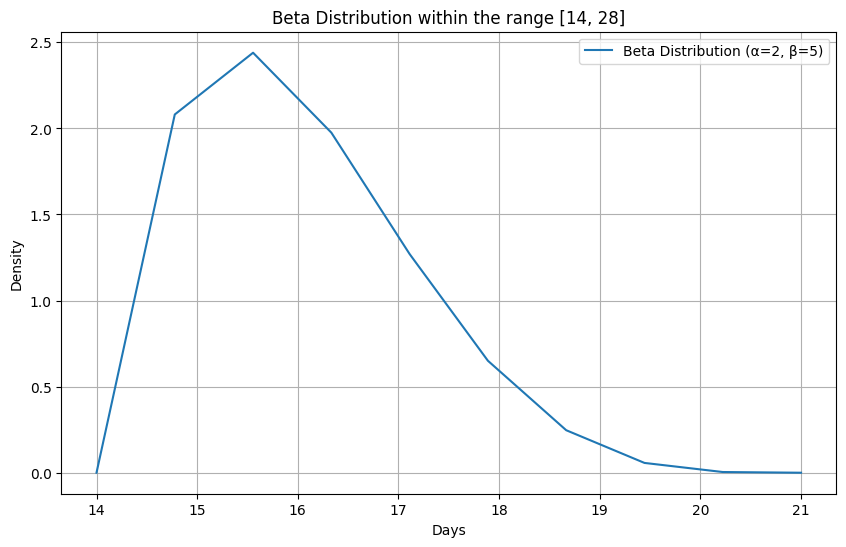

In [52]:

# Parameters for the Beta distribution
alpha, beta_param = 2, 5  

# Scaling parameters to transform the Beta distribution to fit within the range [14, 28]
a, b = 14, 21

# Generate Beta distribution values
x = np.linspace(0, 1, 10)
y = beta.pdf(x, alpha, beta_param) #this value is within the range [0, 1] so we use x_transformed = a + (b - a) * x to convert it between the range [a, b]

# Transform x to fit within the desired range [14, 28]
x_transformed = a + (b - a) * x

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_transformed, y, label=f'Beta Distribution (α={alpha}, β={beta_param})')
plt.title('Beta Distribution within the range [14, 28]')
plt.xlabel('Days')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
#The graph shows that the probability of getting recovery day of around 16-18 is the greatest
#And getting a recovery rate more than 21 is relatively less as we want people to recover more than die

In [53]:
import numpy as np

def assign_recovery_days():
    alpha=2
    beta_param=5
    range_start=14
    range_end=28
    # Generate random values from a Beta distribution
    beta_value = np.random.beta(alpha, beta_param)
    
    # Scale and shift the Beta distribution values to fit the desired range
    recovery_day = range_start + (range_end - range_start) * beta_value
    
    return recovery_day

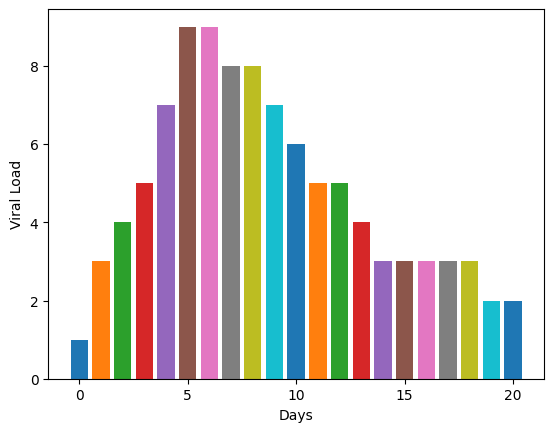

In [54]:
#Viral Load plot Discretized to make it simpler
vl_array = [1, 3, 4, 5, 7, 9, 9, 8, 8, 7, 6, 5, 5, 4, 3, 3, 3, 3, 3, 2, 2]
for day in range(21):
    plt.bar(day, vl_array[day])
    plt.xlabel('Days')
    plt.ylabel('Viral Load')

In [55]:
def viral_load(day): 
    vl_array = [1, 3, 4, 5, 7, 9, 9, 8, 8, 7, 6, 5, 5, 4, 3, 3, 3, 3, 3, 2, 2]
    day_index = max(0, min(day-1, len(vl_array)-1))  # Ensure day is within bounds
    return vl_array[day_index]


In [56]:
def transmission_probability(distance, VL):
    Tm = 1 #transmission_probability maximum is 1
    lambda_decay = 2 # a constant which controls the exponential decay
    Td = Tm*np.exp(-distance / VL)
    return Td

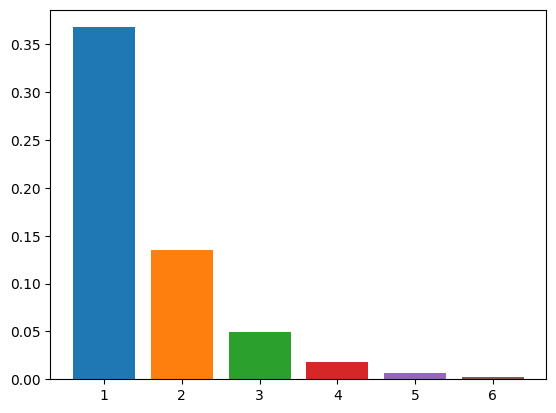

In [57]:
for distance in range(1, 7):
    plt.bar(distance, transmission_probability(distance, viral_load(1)))

#This plot demonstrates how the transmission probability decreseas when the distance and VL is changed 
#I have used the viral load of day 1 for demonstration purpose only

In [58]:
#initiallizing individuals
num_individuals = 100
initial_infected = 5
total_deaths = 0
total_new_infections = 0
total_recovered = 0
number_of_reinfections = 0
height, width = 250, 250 # height and width of the plot

individuals = [] #defining a class to store all the individuals info

for i in range(1, num_individuals + 1):
    if i <= initial_infected:
        status = "infected"
        days_infected = 1
        recovery_time = assign_recovery_days()
    else: 
        status = "susceptible"
        days_infected = 0
        recovery_time = None
    individual = {
        'status' : status, 
        'days_infected' : days_infected, 
        'recovery_time' : recovery_time, 
        'position' :  np.random.rand(2) * np.array([width, height]),  #gives a random position(x, y) within the height and width of the plot
        'velocity' : np.random.randn(2) * 2
    }
    individuals.append(individual)

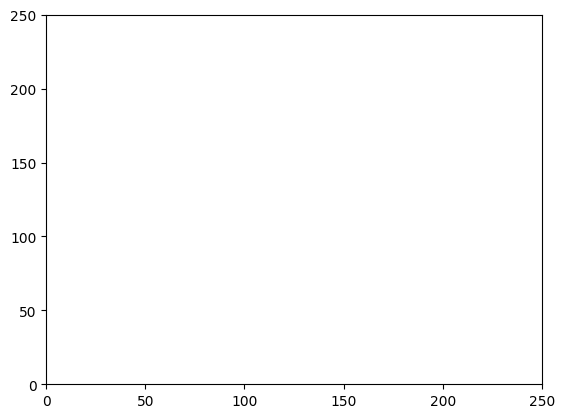

In [59]:
# Initialize the plot
fig, ax = plt.subplots()
ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Initialize scatter plot without any points
scat = ax.scatter([], [], s=40)

def init():
    """Initialize the background of the animation."""
    scat.set_offsets(np.empty((0, 2)))  # Use an empty 2D array instead of a list

    #Adding Legends
    ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Infected'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Susceptible'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Dead')],
              loc="upper left", bbox_to_anchor=(0.2, 1.18), ncol=3)
    return (scat,)

In [60]:
def update(frame):
    global total_new_infections, total_deaths, number_of_reinfections, total_recovered
    new_infections_frame = 0
    reinfections_frame = 0
    recovered_frame = 0
    deaths_frame = 0
    """Update the scatter plot for each frame."""
    offsets = []  # List to collect the new positions of each point
    colors = []   # List to collect the colors based on status
    
    # Loop over individuals to update their status and position
    for i, individual in enumerate(individuals):
        # Update positions based on velocity
        if individual['status'] != 'dead':
            individual['position'] += individual['velocity']
        
        # Reflect off walls
            for dim in range(2):
                if individual['position'][dim] <= 0 or individual['position'][dim] >= [width, height][dim]:
                    individual['velocity'][dim] *= -1
                # Ensure the position is within bounds
                    individual['position'][dim] = max(min(individual['position'][dim], [width, height][dim]), 0)
        
        # Check for recovery or death each day
        if individual['status'] == 'infected':
            if individual['days_infected'] >= individual['recovery_time']:
                individual['status'] = 'recovered'
                recovered_frame += 1
            elif individual['days_infected'] > 21:
                individual['status'] = 'dead'
                individual['velocity'] = np.array([0, 0])  # Stops movement
                total_deaths += 1
                deaths_frame += 1
            else: 
                individual['status'] = 'infected'
        # Check for new infections
        if individual['status'] in ['susceptible', 'recovered']:
            for j, other in enumerate(individuals):
                if i != j and other['status'] == 'infected':
                    # Calculate the distance between two individuals
                    distance = np.linalg.norm(individual['position'] - other['position'])
                    # Calculate transmission probability
                    VL = viral_load(other['days_infected'])
                    Tp = transmission_probability(distance, VL)
                    # Determine if transmission occurs
                    if np.random.rand() < Tp:
                        if individual['status'] == 'susceptible':
                            total_new_infections += 1
                        elif individual['status'] == 'recovered':
                            number_of_reinfections += 1
                        individual['status'] = 'infected'
                        individual['days_infected'] = 1
                        individual['recovery_time'] = assign_recovery_days()
                        break  # Once infected, no need to check further
        
        # Update days_infected count for those infected
        if individual['status'] == 'infected':
            individual['days_infected'] += 1
            
        
        # Collect new positions and determine colors based on status
        offsets.append(individual['position'])
        
        # Determine colors based on status and add to colors list
        if individual['status'] == 'susceptible':
            colors.append('blue')
        elif individual['status'] == 'infected':
            colors.append('red')
        elif individual['status'] == 'recovered':
            colors.append('green')
        else:  # Dead
            colors.append('gray')
    
    # Update scatter plot's offsets and colors
    scat.set_offsets(np.array(offsets))
    scat.set_color(colors)

    # Updating the frame title
    ax.set_title(f"Day {frame}")

    total_new_infections += new_infections_frame
    number_of_reinfections += reinfections_frame
    total_recovered += recovered_frame
    
    infection_text.set_text(f"New Infections: {total_new_infections}")
    reinfection_text.set_text(f"Re-Infections: {number_of_reinfections}")
    death_text.set_text(f"Deaths: {total_deaths}")
    recovered_text.set_text(f"Total Recovered: {total_recovered}")
    
    return (scat,)

In [61]:
#plotting the animation
infection_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
reinfection_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
death_text = ax.text(0.02, 0.85, '', transform=ax.transAxes)
recovered_text = ax.text(0.02, 0.80, '', transform=ax.transAxes)
# Creating the animation
ani = FuncAnimation(fig, update, frames=range(100), init_func=init, blit=True, interval=200)
ani.save('covid_simulation2.mp4', writer='ffmpeg', fps=5)
HTML(ani.to_jshtml())
